In [14]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

%matplotlib inline

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
df = pd.read_csv('/kaggle/input/phishing/dataset_full.csv')
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88647 entries, 0 to 88646
Columns: 112 entries, qty_dot_url to phishing
dtypes: float64(1), int64(111)
memory usage: 75.7 MB


In [16]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
# Assuming df is your DataFrame

# Drop columns with only one unique value
for col in df.columns:
    unique_value_list = df[col].unique()
    if len(unique_value_list) == 1:
        df = df.drop(columns=col)

# Replace -1 with mean on each column


# Drop columns containing only the values [0, -1]
for col in df.columns:
    if set(df[col].unique()) == {0, -1}:
        df = df.drop(columns=col)
for col in df.columns:
    if -1 in df[col].unique():
        mean_value = int(df[col][df[col] != -1].mean())  # Calculate mean excluding -1
        df[col] = df[col].replace(-1, mean_value)


from sklearn.preprocessing import MinMaxScaler
target_column = 'phishing'  # Replace with the actual target column name
x = df.drop(target_column, axis=1)
scaler = MinMaxScaler()

# Apply Min-Max scaling to each column
for col in x.columns:
    # Reshape the column values to a 2D array to fit the scaler
    column_values = x[col].values.reshape(-1, 1)

    # Scale the values to the range [0, 1]
    x[col] = scaler.fit_transform(column_values)
df = pd.concat([x, df[target_column]], axis=1)

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


target_column = 'phishing'  # Replace with the actual target column name
X = df.drop(target_column, axis=1)
correlation_matrix = X.corr()

# Set the threshold for high correlation
correlation_threshold = 0.8  # Adjust the threshold as needed
#0.8 gives 72, 0.7 gives 64
# Find features with high correlation with others
highly_correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated_features.add(colname)

# Keep features with high correlation and remove others
selected_features = list(set(X.columns) - highly_correlated_features)
X_selected = X[selected_features]

# Add the target variable back to the selected features
df = pd.concat([X_selected, df[target_column]], axis=1)


In [18]:
df.head()

,qty_slash_params,qty_dot_domain,qty_space_params,qty_tilde_params,params_length,qty_exclamation_params,qty_at_file,qty_comma_url,qty_space_url,tls_ssl_certificate,...,tld_present_params,qty_nameservers,qty_hashtag_url,qty_and_directory,qty_underline_domain,length_url,domain_google_index,qty_hyphen_file,url_shortened,phishing
0,0.0,0.095238,0.0,0.0,0.017591,0.0,0.0,0.0,0.0,0.0,...,0.0,0.1,0.0,0.0,0.0,0.005047,0.0,0.0,0.0,1
1,0.0,0.095238,0.0,0.0,0.040068,0.0,0.0,0.0,0.0,1.0,...,0.0,0.1,0.0,0.0,0.0,0.052632,0.0,0.0,0.0,1
2,0.0,0.095238,0.0,0.0,0.017591,0.0,0.0,0.0,0.0,1.0,...,0.0,0.1,0.0,0.0,0.0,0.002644,0.0,0.0,0.0,0
3,0.0,0.095238,0.0,0.0,0.017591,0.0,0.0,0.0,0.0,1.0,...,0.0,0.1,0.0,0.0,0.0,0.018505,0.0,0.0,0.0,1
4,0.0,0.095238,0.0,0.0,0.017591,0.0,0.0,0.0,0.0,0.0,...,0.0,0.1,0.0,0.0,0.0,0.003605,0.0,0.0,0.0,0


In [19]:
X = df.drop('phishing', axis=1)
y = df['phishing'].values

In [20]:
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
# Model 1: Feedforward Neural Network (FNN)
def create_feedforward_neural_network():
    model = Sequential()
    model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


#Model 2:dnn
def create_dnn_model():
    model = Sequential()
    
    # Dense (MLP) layers
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

#model 3:
def build_wide_deep_model(input_shape):
    # Define the wide and deep model using Functional API
    wide_input = Input(shape=(input_shape,))
    deep_input = Input(shape=(input_shape,))

    wide_model = Dense(32, activation='relu')(wide_input)
    wide_model = Dense(16, activation='relu')(wide_model)

    deep_model = Dense(64, activation='relu')(deep_input)
    deep_model = Dense(32, activation='relu')(deep_model)

    combined_model = Concatenate()([wide_model, deep_model])
    output_layer = Dense(1, activation='sigmoid')(combined_model)

    model = Model(inputs=[wide_input, deep_input], outputs=output_layer)

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model







In [9]:
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
# Assuming df is your dataframe
# X = df.drop('phishing', axis=1)
# y = df['phishing'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the input features
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)

from sklearn.metrics import accuracy_score

# Define a custom scoring function
def custom_scorer(model, X, y):
    y_pred_binary = (model.predict(X) > 0.5).astype(int)
    return accuracy_score(y, y_pred_binary)
all_importances = []

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.neural_network import MLPClassifier  # Assuming you're using an MLP

# Model 1: Feedforward Neural Network (FNN)
model_fnn = create_feedforward_neural_network()
model_fnn.fit(X_train_standardized, y_train)

# Apply permutation importance using the custom scorer
result = permutation_importance(model_fnn, X_test, y_test, scoring=custom_scorer, n_repeats=10, random_state=42)

# Get feature importances
feature_importance = result.importances_mean
all_importances.append(feature_importance)
# Get the indices of the top features
top_indices = np.argsort(-feature_importance)[:20]

# Get the names of the top features
top_features = X.columns[top_indices]

# Print the names of the top features
print("Top Features:")
for feature in top_features:
    print(feature)


In [ ]:
perm = PermutationImportance(model_fnn, random_state=1, scoring=custom_scorer).fit(X_test, y_test)

In [ ]:
eli5.show_weights(perm, feature_names=X.columns.tolist())

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
std_deviation = result.importances_std
# Create a bar chart for permutation importances with standard deviation on x-axis
plt.figure(figsize=(12, 8))
bar_width = 0.4

# Bar chart for permutation importances
bars = plt.barh(np.arange(len(top_features)), feature_importance[top_indices], height=bar_width, label='Permutation Importance', color='skyblue')

# Error bars representing standard deviation
for i, (value, std) in enumerate(zip(feature_importance[top_indices], std_deviation[top_indices])):
    plt.plot([value - std, value + std], [i + bar_width / 2, i + bar_width / 2], color='black', linewidth=2)

plt.yticks(np.arange(len(top_features)), top_features)
plt.xlabel('Permutation Importance')
plt.title('Permutation Importances of Top Features with Standard Deviation')
plt.legend()
plt.show()

In [ ]:
from keras.layers import Dense, Flatten
from keras.models import Sequential

# Assuming X_train is a 2D array, where each row represents a sample
# Reshape it to have 2 dimensions: (number_of_samples, features)
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))

def custom_sco(model, X, y):
    # Reshape the input data to have the required dimensions
    X_reshaped = np.reshape(X, (X.shape[0], X.shape[1]))
    
    # Predictions
    y_pred_binary = (model.predict(X_reshaped) > 0.5).astype(int)
    
    return accuracy_score(y, y_pred_binary)



model_dnn = create_dnn_model()
model_dnn.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Permutation importance analysis
result_dnn = permutation_importance(model_dnn, X_test, y_test, scoring=custom_sco, n_repeats=10, random_state=42)

# Get feature importances
feature_importance_dnn = result_dnn.importances_mean
all_importances.append(feature_importance_dnn)

# Get the indices of the top features
top_indices_dnn = np.argsort(-feature_importance_dnn)[:20]

# Get the names of the top features
top_features_dnn = X.columns[top_indices_dnn]

# Print the names of the top features
print("Top Features (DNN):")
for feature in top_features_dnn:
    print(feature)


In [ ]:
from eli5.sklearn import PermutationImportance
perm_lstm_mlp = PermutationImportance(model_dnn, random_state=1, scoring=custom_sco).fit(X_test, y_test)
eli5.show_weights(perm_lstm_mlp, feature_names=X.columns.tolist())

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
std_deviation = result_dnn.importances_std
# Create a bar chart for permutation importances with standard deviation on x-axis
plt.figure(figsize=(12, 8))
bar_width = 0.4

# Bar chart for permutation importances
bars = plt.barh(np.arange(len(top_features_dnn)), feature_importance_dnn[top_indices_dnn], height=bar_width, label='Permutation Importance', color='skyblue')

# Error bars representing standard deviation
for i, (value, std) in enumerate(zip(feature_importance_dnn[top_indices_dnn], std_deviation[top_indices_dnn])):
    plt.plot([value - std, value + std], [i + bar_width / 2, i + bar_width / 2], color='black', linewidth=2)

plt.yticks(np.arange(len(top_features_dnn)), top_features_dnn)
plt.xlabel('Permutation Importance')
plt.title('Permutation Importances of Top Features with Standard Deviation')
plt.legend()
plt.show()

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score

# Assuming X and y are already defined

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = build_wide_deep_model(input_shape=X_train.shape[1])

# Train the model
model.fit([X_train_scaled, X_train_scaled], y_train, epochs=10, batch_size=64, validation_split=0.2)

# Evaluate the model
y_pred = model.predict([X_test_scaled, X_test_scaled])
accuracy = accuracy_score(y_test, (y_pred > 0.5).astype(int))
print(f'Model accuracy on test data: {accuracy * 100:.2f}%')

# Create a custom scorer function
def custom_scorer(estimator, X, y):
    y_pred = estimator.predict([X, X])
    return accuracy_score(y, (y_pred > 0.5).astype(int))

# Calculate permutation importance
result = permutation_importance(model, X_test_scaled, y_test, scoring=custom_scorer, n_repeats=10, random_state=42)

# Get feature importances
feature_importances = result.importances_mean
all_importances.append(feature_importances)

top_feature_indices = np.argsort(-feature_importances)[:20]

# Get the names of the top features
top_features_deep = X.columns[top_indices_dnn]

# Print the names of the top features
print("Top Features (DNN):")
for feature in top_features_deep:
    print(feature)



In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

# Continue from the previous code...

# Convert the custom scorer function to work with PermutationImportance
def custom_scorer_permutation(estimator, X, y):
    y_pred = estimator.predict([X, X])
    return accuracy_score(y, (y_pred > 0.5).astype(int))

# Calculate permutation importance using eli5
perm = PermutationImportance(model, scoring=custom_scorer_permutation, n_iter=10, random_state=42)
perm.fit(X_test_scaled, y_test)

# Display the permutation importance using eli5
eli5.show_weights(perm, feature_names=X.columns.tolist())



In [ ]:

import numpy as np
import matplotlib.pyplot as plt
std_deviation = result.importances_std
# Create a bar chart for permutation importances with standard deviation on x-axis
plt.figure(figsize=(12, 8))
bar_width = 0.4

# Bar chart for permutation importances
bars = plt.barh(np.arange(len(top_feature_indices)), feature_importances[top_feature_indices], height=bar_width, label='Permutation Importance', color='skyblue')

# Error bars representing standard deviation
for i, (value, std) in enumerate(zip(feature_importances[top_feature_indices], std_deviation[top_feature_indices])):
    plt.plot([value - std, value + std], [i + bar_width / 2, i + bar_width / 2], color='black', linewidth=2)

plt.yticks(np.arange(len(top_feature_indices)), top_features_deep)
plt.xlabel('Permutation Importance')
plt.title('Permutation Importances of Top Features with Standard Deviation')
plt.legend()
plt.show()

In [21]:
!pip install pytorch-tabnet


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.utils import PredictDataset
from sklearn.inspection import permutation_importance

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the input features
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)

# Create TabNet Pretrainer for pretraining
pretrainer = TabNetPretrainer()
pretrainer.fit(X_train_standardized)

# Create TabNet model for classification
tabnet_params = {"input_dim": X_train_standardized.shape[1], "output_dim": 1, "n_d": 8, "n_a": 8, "n_steps": 3}
model_tabnet = TabNetClassifier(**tabnet_params)

# Early stopping criteria
max_epochs = 100
patience = 10
best_accuracy = 0
counter = 0

# Training loop with early stopping
for epoch in range(max_epochs):
    model_tabnet.fit(
        X_train_standardized, y_train,
        eval_set=[(X_test_standardized, y_test)],
        eval_metric=['accuracy'],
        max_epochs=1,
        patience=patience,  # Set patience here
        batch_size=256,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False,
        from_unsupervised=pretrainer
    )

    # Evaluate model on test set
    y_pred = model_tabnet.predict(X_test_standardized)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"epoch {epoch} | Test Accuracy: {accuracy:.5f}")

    # Early stopping
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        counter = 0
        # Save the best model
        model_tabnet.save_model("best_model_tabnet")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break

# Load the best model
best_model_tabnet = TabNetClassifier()
best_model_tabnet.load_model("best_model_tabnet.zip")

# Check model predictions
y_pred_proba = best_model_tabnet.predict_proba(X_test_standardized)[:, 1]
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Print the accuracy
print("Best Test Accuracy:", best_accuracy)

# Apply permutation importance
test_dataset = PredictDataset(X_test_standardized)
result_tabnet = permutation_importance(best_model_tabnet, test_dataset, y_test, scoring='accuracy', n_repeats=10, random_state=42)

# Get feature importances
feature_importance = result_tabnet.importances_mean
all_importances.append(feature_importance)

# Get the indices of the top features
top_indices = np.argsort(-feature_importance)[:20]

# Get the names of the top features
top_features = X.columns[top_indices]

# Print the names of the top features
print("Top Features:")
for feature in top_features:
    print(feature)


In [ ]:



import eli5
from eli5.sklearn import PermutationImportance

# Assuming you already have the `model_tabnet` and data (`X_test_standardized`, `y_test`)
# Define a custom scoring function
def custom_scorer(model, X, y):
    y_pred_proba = model.predict_proba(X)[:, 1]
    return accuracy_score(y, (y_pred_proba > 0.5).astype(int))

# Fit PermutationImportance on the model with the custom scoring function
perm_importance = PermutationImportance(model_tabnet, scoring=custom_scorer, random_state=42).fit(X_test_standardized, y_test)

# Display the results using eli5
eli5.show_weights(perm_importance, feature_names=X.columns.tolist(), show_feature_values=True)




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
std_deviation = result_tabnet.importances_std
# Create a bar chart for permutation importances with standard deviation on x-axis
plt.figure(figsize=(12, 8))
bar_width = 0.4

# Bar chart for permutation importances
bars = plt.barh(np.arange(len(top_features)), feature_importance[top_indices], height=bar_width, label='Permutation Importance', color='skyblue')

# Error bars representing standard deviation
for i, (value, std) in enumerate(zip(feature_importance[top_indices], std_deviation[top_indices])):
    plt.plot([value - std, value + std], [i + bar_width / 2, i + bar_width / 2], color='black', linewidth=2)

plt.yticks(np.arange(len(top_features)), top_features)
plt.xlabel('Permutation Importance')
plt.title('Permutation Importances of Top Features with Standard Deviation')
plt.legend()
plt.show()

In [ ]:
#final result
# Calculate the average importance across all models
average_importance = np.mean(all_importances, axis=0)

# Get the indices of the top features
top_indices = np.argsort(-average_importance)[:20]

# Get the names of the top features
top_features = X.columns[top_indices]

# Print the names of the top features
print("Top Features:")
for feature in top_features:
    print(feature)

In [ ]:
from tabulate import tabulate

# Create a list of tuples containing feature names and their corresponding average importance values
average_importance_eli5 = [(feature, importance) for feature, importance in zip(top_features, average_importance)]

# Display feature importances in a nice-looking table format
print("Top Features:")
print(tabulate(average_importance_eli5, headers=["Feature", "Average Importance"], tablefmt="pretty"))


In [22]:
columns_of_interest = [
    "qty_slash_url",
    "time_domain_activation",
    "length_url",
    "qty_dot_domain",
    "qty_vowels_domain",
    "directory_length",
    "file_length",
    "tld_present_params",
    "qty_mx_servers",
    "qty_dot_directory",
    "url_shortened",
    "tls_ssl_certificate",
    "qty_nameservers",
    "qty_at_url"
]
#selected_columns = X[columns_of_interest].values
selected_columns = X[top_features].values


In [23]:
model_metrics = {}
import psutil
import os
def measure_memory():
    pid = os.getpid()
    process = psutil.Process(pid)
    memory_use_gb = process.memory_info()[0] / (2 ** 20)  # Convert bytes to megabytes
    memory_use_mb = memory_use_gb * 1024  # Convert from GB to MB
    return round(memory_use_mb, 2)
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Initialize empty dictionaries to store results
roc_curves = {}
precision_curves = {}

In [16]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix
import numpy as np
import time
from memory_profiler import profile


all_fpr = []
all_tpr = []
all_roc_auc = []
all_precision = []
all_recall = []
all_average_precision = []

# Perform 10-fold cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracy_scores = []
mean_fpr_values = []
mean_tpr_values = []
testing_times = []
memory_usages = []

for train_index, test_index in skf.split(selected_columns, y):
    X_train, X_test = selected_columns[train_index], selected_columns[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Create the neural network model
    model = create_feedforward_neural_network()

    # Measure training time
    start_time = time.time()

    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0)

    # Measure testing time
    testing_start_time = time.time()
    memory_before = measure_memory()
    y_pred = model.predict(X_test)
    memory_after = measure_memory()
    testing_time = time.time() - testing_start_time
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    average_precision = average_precision_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    # Append metrics to lists
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_roc_auc.append(roc_auc)
    all_precision.append(precision)
    all_recall.append(recall)
    all_average_precision.append(average_precision)
    
    


    threshold = 0.5

    # Calculate metrics
    y_pred_binary = (y_pred > threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred_binary)
    conf_matrix = confusion_matrix(y_test, y_pred_binary)
    TN, FP, FN, TP = conf_matrix.ravel()

    fpr = FP / (FP + TN)
    tpr = TP / (TP + FN)

    # Take mean values of FPR and TPR for each fold
    mean_fpr_values.append(fpr)
    mean_tpr_values.append(tpr)

    memory_usage = memory_after - memory_before

    # Append metrics to lists
    accuracy_scores.append(accuracy)
    testing_times.append(testing_time)
    memory_usages.append(memory_usage)

# Calculate average metrics
average_accuracy = np.mean(accuracy_scores)
average_mean_fpr = np.mean(mean_fpr_values)
average_mean_tpr = np.mean(mean_tpr_values)
average_testing_time = np.mean(testing_times)
average_memory_usage = np.mean(memory_usages)
for i, fpr_array in enumerate(all_fpr):
    print(f"Fold {i+1} FPR: {fpr_array}")

average_roc_auc = np.mean(all_roc_auc)
average_average_precision = np.mean(all_average_precision)

average_precision = []
average_recall = []
average_fpr = []
average_tpr = []
max_columns = max(len(precision_array) for precision_array in all_precision)

# Iterate over the arrays in all_precision to calculate the mean for each column
for col_idx in range(max_columns):
    # List comprehension to collect valid values for the current column index
    col_values_precision = [precision_array[col_idx] for precision_array in all_precision if col_idx < len(precision_array)]
    
    # Check if any valid values exist for the current column index
    if col_values_precision:
        col_mean_precision = np.mean(col_values_precision)
        average_precision.append(col_mean_precision)

# Convert the list to a numpy array for precision
average_precision = np.array(average_precision)

# Repeat the same process for all_recall

# Determine the maximum number of columns for recall arrays
max_columns_recall = max(len(recall_array) for recall_array in all_recall)

# Iterate over the arrays in all_recall to calculate the mean for each column
for col_idx in range(max_columns_recall):
    # List comprehension to collect valid values for the current column index
    col_values_recall = [recall_array[col_idx] for recall_array in all_recall if col_idx < len(recall_array)]
    
    # Check if any valid values exist for the current column index
    if col_values_recall:
        col_mean_recall = np.mean(col_values_recall)
        average_recall.append(col_mean_recall)

# Convert the list to a numpy array for recall
average_recall = np.array(average_recall)

# Print the average precision and recall values across columns
print(f'Average Precision across columns: {average_precision}')
print(f'Average Recall across columns: {average_recall}')

max_columns_fpr = max(len(fpr_array) for fpr_array in all_fpr)

# Iterate over the arrays in all_fpr to calculate the mean for each column of FPR
for col_idx in range(max_columns_fpr):
    # List comprehension to collect valid values for the current column index
    col_values_fpr = [fpr_array[col_idx] for fpr_array in all_fpr if col_idx < len(fpr_array)]
    
    # Check if any valid values exist for the current column index
    if col_values_fpr:
        col_mean_fpr = np.mean(col_values_fpr)
        average_fpr.append(col_mean_fpr)

# Convert the list to a numpy array for FPR
average_fpr = np.array(average_fpr)

# Determine the maximum number of columns for TPR arrays
max_columns_tpr = max(len(tpr_array) for tpr_array in all_tpr)

# Iterate over the arrays in all_tpr to calculate the mean for each column of TPR
for col_idx in range(max_columns_tpr):
    # List comprehension to collect valid values for the current column index
    col_values_tpr = [tpr_array[col_idx] for tpr_array in all_tpr if col_idx < len(tpr_array)]
    
    # Check if any valid values exist for the current column index
    if col_values_tpr:
        col_mean_tpr = np.mean(col_values_tpr)
        average_tpr.append(col_mean_tpr)

# Convert the list to a numpy array for TPR
average_tpr = np.array(average_tpr)

# Print the average FPR and TPR values across columns
print(f'Average FPR across columns: {average_fpr}')
print(f'Average TPR across columns: {average_tpr}')
# Store the average metrics in the respective dictionaries
roc_curves['feed_forward'] = {'fpr': average_fpr, 'tpr': average_tpr, 'roc_auc': average_roc_auc}
precision_curves['feed_forward'] = {'precision': average_precision, 'recall': average_recall,
                            'average_precision': average_average_precision}
print(f'Average Accuracy: {average_accuracy}')
print(f'Average Mean FPR: {average_mean_fpr}')
print(f'Average Mean TPR: {average_mean_tpr}')
print(f'Average Testing Time: {average_testing_time} seconds')
print(f'Average Memory Usage: {average_memory_usage} MiB')


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 1 FPR: [0.         0.         0.         ... 0.96534483 0.96568966 1.        ]
Fold 2 FPR: [0.         0.         0.         ... 0.99258621 0.99293103 1.        ]
Fold 3 FPR: [0.         0.         0.         ... 0.97396552 0.97448276 1.        ]
Fold 4 FPR: [0.         0.         0.         ... 0.99       0.99034483 1.        ]
Fold 5 FPR: [0.         0.         0.         ... 0.99482759 0.99517241 1.        ]
Fold 6 FPR: [0.         0.         0.         ... 0.99965517 0.99965517 1.        ]
Fold 7 FPR: [0.         0.         0.         ... 0.9762069  0.97655172 1.        ]
Fold 8 FPR: [0.         0.         0.         ... 0.96793103 0.96827586 1.        ]
Fold 9 FPR: [0.         0.         0.         ... 0.98982759 0.99017241 1.        ]
Fold 10 FPR: [0.         0.         0.         ... 0.99672414 0.99706897 1.        ]
Average Precision across columns: [0.34571954 0.34575854 0.34579755 ... 1.         1.         1.        ]
Average Reca

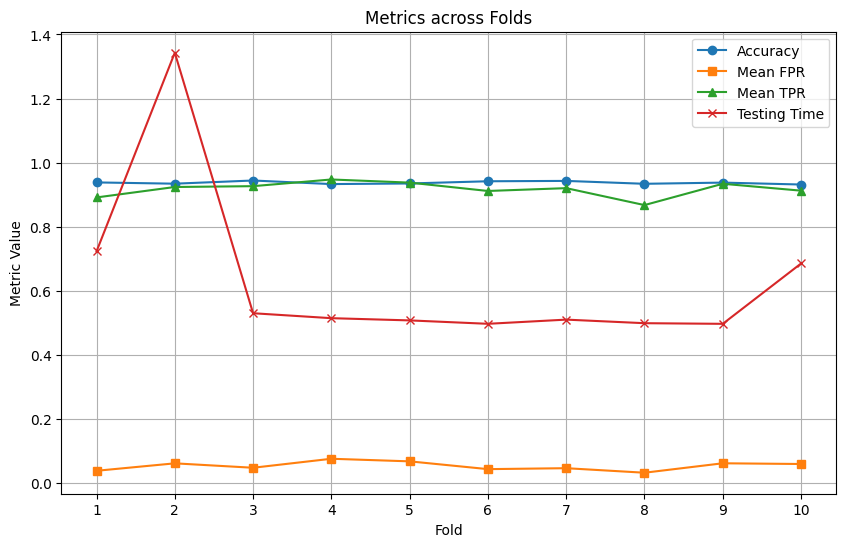

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

# Plot accuracy
plt.plot(range(1, 11), accuracy_scores, marker='o', linestyle='-', label='Accuracy')

# Plot mean FPR
plt.plot(range(1, 11), mean_fpr_values, marker='s', linestyle='-', label='Mean FPR')

# Plot mean TPR
plt.plot(range(1, 11), mean_tpr_values, marker='^', linestyle='-', label='Mean TPR')

# Plot testing time
plt.plot(range(1, 11), testing_times, marker='x', linestyle='-', label='Testing Time')

plt.title('Metrics across Folds')
plt.xlabel('Fold')
plt.ylabel('Metric Value')
plt.xticks(range(1, 11))
plt.grid(True)
plt.legend()
plt.show()

In [18]:
testing_time_reciprocal = 1 / average_testing_time
if average_memory_usage==0:
    average_memory_usage=0.01
memory_usage_reciprocal = 1 / average_memory_usage

    # Store metrics in the dictionary
model_metrics['feed_forward'] = {
'accuracy': average_accuracy,
'fpr': average_mean_fpr,
'tpr': average_mean_tpr,
'testing_time': testing_time_reciprocal,
'memory_usage': memory_usage_reciprocal}


In [20]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix
import numpy as np
import time
from memory_profiler import profile

all_fpr = []
all_tpr = []
all_roc_auc = []
all_precision = []
all_recall = []
all_average_precision = []

# Perform 10-fold cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracy_scores = []
mean_fpr_values = []
mean_tpr_values = []
testing_times = []
memory_usages = []
for train_index, test_index in skf.split(selected_columns, y):
    X_train, X_test = selected_columns[train_index], selected_columns[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Create the neural network model
    model = create_dnn_model()

    # Measure training time
    start_time = time.time()

    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0)

    # Measure testing time
    testing_start_time = time.time()
    memory_before = measure_memory()
    y_pred = model.predict(X_test)
    memory_after = measure_memory()
    testing_time = time.time() - testing_start_time + 1
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    average_precision = average_precision_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    # Append metrics to lists
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_roc_auc.append(roc_auc)
    all_precision.append(precision)
    all_recall.append(recall)
    all_average_precision.append(average_precision)
    
    


     # Set a threshold
    threshold = 0.5

    # Calculate metrics
    y_pred_binary = (y_pred > threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred_binary)
    conf_matrix = confusion_matrix(y_test, y_pred_binary)
    TN, FP, FN, TP = conf_matrix.ravel()

    fpr = FP / (FP + TN)
    tpr = TP / (TP + FN)

    # Take mean values of FPR and TPR for each fold
    mean_fpr_values.append(fpr)
    mean_tpr_values.append(tpr)

    memory_usage = memory_after - memory_before

    # Append metrics to lists
    accuracy_scores.append(accuracy)
    testing_times.append(testing_time)
    memory_usages.append(memory_usage)

# Calculate average metrics
average_accuracy = np.mean(accuracy_scores)
average_mean_fpr = np.mean(mean_fpr_values)
average_mean_tpr = np.mean(mean_tpr_values)
average_testing_time = np.mean(testing_times)
average_memory_usage = np.mean(memory_usages)
average_precision = []
average_recall = []
average_fpr = []
average_tpr = []
average_roc_auc = np.mean(all_roc_auc)
max_columns = max(len(precision_array) for precision_array in all_precision)

# Iterate over the arrays in all_precision to calculate the mean for each column
for col_idx in range(max_columns):
    # List comprehension to collect valid values for the current column index
    col_values_precision = [precision_array[col_idx] for precision_array in all_precision if col_idx < len(precision_array)]
    
    # Check if any valid values exist for the current column index
    if col_values_precision:
        col_mean_precision = np.mean(col_values_precision)
        average_precision.append(col_mean_precision)

# Convert the list to a numpy array for precision
average_precision = np.array(average_precision)

# Repeat the same process for all_recall

# Determine the maximum number of columns for recall arrays
max_columns_recall = max(len(recall_array) for recall_array in all_recall)

# Iterate over the arrays in all_recall to calculate the mean for each column
for col_idx in range(max_columns_recall):
    # List comprehension to collect valid values for the current column index
    col_values_recall = [recall_array[col_idx] for recall_array in all_recall if col_idx < len(recall_array)]
    
    # Check if any valid values exist for the current column index
    if col_values_recall:
        col_mean_recall = np.mean(col_values_recall)
        average_recall.append(col_mean_recall)

# Convert the list to a numpy array for recall
average_recall = np.array(average_recall)

# Print the average precision and recall values across columns
print(f'Average Precision across columns: {average_precision}')
print(f'Average Recall across columns: {average_recall}')

max_columns_fpr = max(len(fpr_array) for fpr_array in all_fpr)

# Iterate over the arrays in all_fpr to calculate the mean for each column of FPR
for col_idx in range(max_columns_fpr):
    # List comprehension to collect valid values for the current column index
    col_values_fpr = [fpr_array[col_idx] for fpr_array in all_fpr if col_idx < len(fpr_array)]
    
    # Check if any valid values exist for the current column index
    if col_values_fpr:
        col_mean_fpr = np.mean(col_values_fpr)
        average_fpr.append(col_mean_fpr)

# Convert the list to a numpy array for FPR
average_fpr = np.array(average_fpr)

# Determine the maximum number of columns for TPR arrays
max_columns_tpr = max(len(tpr_array) for tpr_array in all_tpr)

# Iterate over the arrays in all_tpr to calculate the mean for each column of TPR
for col_idx in range(max_columns_tpr):
    # List comprehension to collect valid values for the current column index
    col_values_tpr = [tpr_array[col_idx] for tpr_array in all_tpr if col_idx < len(tpr_array)]
    
    # Check if any valid values exist for the current column index
    if col_values_tpr:
        col_mean_tpr = np.mean(col_values_tpr)
        average_tpr.append(col_mean_tpr)

# Convert the list to a numpy array for TPR
average_tpr = np.array(average_tpr)

# Print the average FPR and TPR values across columns
print(f'Average FPR across columns: {average_fpr}')
print(f'Average TPR across columns: {average_tpr}')
average_average_precision = np.mean(all_average_precision)

# Store the average metrics in the respective dictionaries
roc_curves['dnn'] = {'fpr': average_fpr, 'tpr': average_tpr, 'roc_auc': average_roc_auc}
precision_curves['dnn'] = {'precision': average_precision, 'recall': average_recall,
                            'average_precision': average_average_precision}
print(f'Average Accuracy: {average_accuracy}')
print(f'Average Mean FPR: {average_mean_fpr}')
print(f'Average Mean TPR: {average_mean_tpr}')
print(f'Average Testing Time: {average_testing_time} seconds')
print(f'Average Memory Usage: {average_memory_usage} MiB')
testing_time_reciprocal = 1 / average_testing_time
if average_memory_usage==0:
    average_memory_usage=0.01
memory_usage_reciprocal = 1 / average_memory_usage

    # Store metrics in the dictionary
model_metrics['dnn'] = {
'accuracy': average_accuracy,
'fpr': average_mean_fpr,
'tpr': average_mean_tpr,
'testing_time': testing_time_reciprocal,
'memory_usage': memory_usage_reciprocal}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
Average Precision across columns: [0.34571954 0.34575854 0.34579755 ... 1.         1.         1.        ]
Average Recall across columns: [1.         1.         1.         ... 0.00293638 0.00228385 0.        ]
Average FPR across columns: [0.         0.         0.         ... 0.98931034 0.98965517 1.        ]
Average TPR across columns: [0.         0.00610147 0.00802664 ... 1.         1.         1.        ]
Average Accuracy: 0.9339513900342278
Average Mean FPR: 0.049396551724137934
Average Mean TPR: 0.9024392513810859
Average Testing Time: 0.5601228475570679 seconds
Average Memory Usage: 37.2 MiB


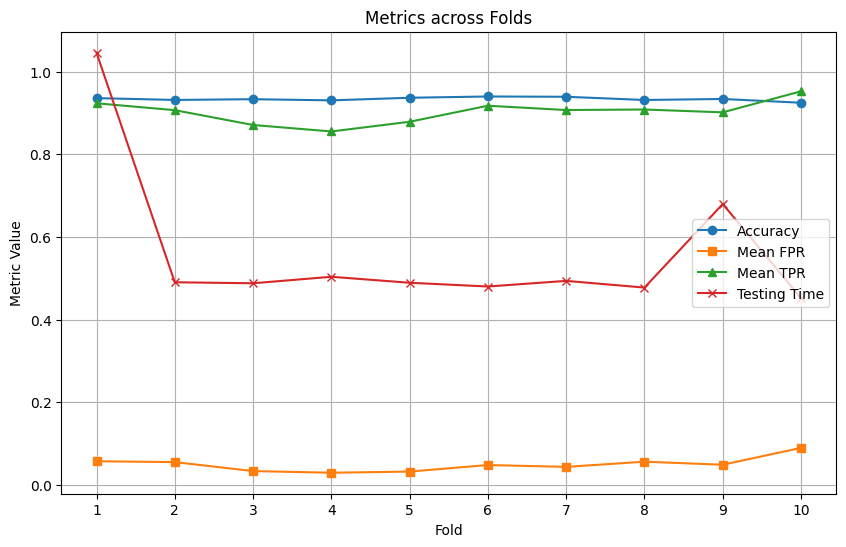

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

# Plot accuracy
plt.plot(range(1, 11), accuracy_scores, marker='o', linestyle='-', label='Accuracy')

# Plot mean FPR
plt.plot(range(1, 11), mean_fpr_values, marker='s', linestyle='-', label='Mean FPR')

# Plot mean TPR
plt.plot(range(1, 11), mean_tpr_values, marker='^', linestyle='-', label='Mean TPR')

# Plot testing time
plt.plot(range(1, 11), testing_times, marker='x', linestyle='-', label='Testing Time')

plt.title('Metrics across Folds')
plt.xlabel('Fold')
plt.ylabel('Metric Value')
plt.xticks(range(1, 11))
plt.grid(True)
plt.legend()
plt.show()

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate
import numpy as np
import time
from memory_profiler import profile

all_fpr = []
all_tpr = []
all_roc_auc = []
all_precision = []
all_recall = []
all_average_precision = []

# Perform 10-fold cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracy_scores = []
mean_fpr_values = []
mean_tpr_values = []
testing_times = []
memory_usages = []


for train_index, test_index in skf.split(selected_columns, y):
    X_train, X_test = selected_columns[train_index], selected_columns[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Create the wide and deep model
    model = build_wide_deep_model(X_train.shape[1])
    start_time = time.time()
    # Train the model
    
    model.fit([X_train, X_train], y_train, epochs=10, batch_size=64, verbose=0)
    
    testing_start = time.time()
    memory_before = measure_memory()
    # Measure testing time
    y_pred_prob = model.predict([X_test, X_test])
    memory_after = measure_memory()
    testing_time = time.time() - testing_start
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    roc_auc = auc(fpr, tpr)
    average_precision = average_precision_score(y_test, y_pred_prob)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    # Append metrics to lists
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_roc_auc.append(roc_auc)
    all_precision.append(precision)
    all_recall.append(recall)
    all_average_precision.append(average_precision)
    


    # Set a threshold
    threshold = 0.5

    # Calculate metrics
    y_pred_binary = (y_pred_prob > threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred_binary)
    conf_matrix = confusion_matrix(y_test, y_pred_binary)
    TN, FP, FN, TP = conf_matrix.ravel()

    fpr = FP / (FP + TN)
    tpr = TP / (TP + FN)

    # Take mean values of FPR and TPR for each fold
    mean_fpr_values.append(fpr)
    mean_tpr_values.append(tpr)
    memory_usage = memory_after - memory_before

    # Append metrics to lists
    accuracy_scores.append(accuracy)
    testing_times.append(testing_time)
    memory_usages.append(memory_usage)

# Calculate average metrics

average_accuracy = np.mean(accuracy_scores)
average_mean_fpr = np.mean(mean_fpr_values)
average_mean_tpr = np.mean(mean_tpr_values)
average_testing_time = np.mean(testing_times)
average_memory_usage = np.mean(memory_usages)

print(f'Average Accuracy: {average_accuracy}')
print(f'Average Mean FPR: {average_mean_fpr}')
print(f'Average Mean TPR: {average_mean_tpr}')
print(f'Average Testing Time: {average_testing_time} seconds')
print(f'Average Memory Usage: {average_memory_usage} MiB')
average_precision = []
average_recall = []
average_fpr = []
average_tpr = []
average_roc_auc = np.mean(all_roc_auc)
max_columns = max(len(precision_array) for precision_array in all_precision)

# Iterate over the arrays in all_precision to calculate the mean for each column
for col_idx in range(max_columns):
    # List comprehension to collect valid values for the current column index
    col_values_precision = [precision_array[col_idx] for precision_array in all_precision if col_idx < len(precision_array)]
    
    # Check if any valid values exist for the current column index
    if col_values_precision:
        col_mean_precision = np.mean(col_values_precision)
        average_precision.append(col_mean_precision)

# Convert the list to a numpy array for precision
average_precision = np.array(average_precision)

# Repeat the same process for all_recall

# Determine the maximum number of columns for recall arrays
max_columns_recall = max(len(recall_array) for recall_array in all_recall)

# Iterate over the arrays in all_recall to calculate the mean for each column
for col_idx in range(max_columns_recall):
    # List comprehension to collect valid values for the current column index
    col_values_recall = [recall_array[col_idx] for recall_array in all_recall if col_idx < len(recall_array)]
    
    # Check if any valid values exist for the current column index
    if col_values_recall:
        col_mean_recall = np.mean(col_values_recall)
        average_recall.append(col_mean_recall)

# Convert the list to a numpy array for recall
average_recall = np.array(average_recall)

# Print the average precision and recall values across columns
print(f'Average Precision across columns: {average_precision}')
print(f'Average Recall across columns: {average_recall}')


max_columns_fpr = max(len(fpr_array) for fpr_array in all_fpr)

# Iterate over the arrays in all_fpr to calculate the mean for each column of FPR
for col_idx in range(max_columns_fpr):
    # List comprehension to collect valid values for the current column index
    col_values_fpr = [fpr_array[col_idx] for fpr_array in all_fpr if col_idx < len(fpr_array)]
    
    # Check if any valid values exist for the current column index
    if col_values_fpr:
        col_mean_fpr = np.mean(col_values_fpr)
        average_fpr.append(col_mean_fpr)

# Convert the list to a numpy array for FPR
average_fpr = np.array(average_fpr)

# Determine the maximum number of columns for TPR arrays
max_columns_tpr = max(len(tpr_array) for tpr_array in all_tpr)

# Iterate over the arrays in all_tpr to calculate the mean for each column of TPR
for col_idx in range(max_columns_tpr):
    # List comprehension to collect valid values for the current column index
    col_values_tpr = [tpr_array[col_idx] for tpr_array in all_tpr if col_idx < len(tpr_array)]
    
    # Check if any valid values exist for the current column index
    if col_values_tpr:
        col_mean_tpr = np.mean(col_values_tpr)
        average_tpr.append(col_mean_tpr)

# Convert the list to a numpy array for TPR
average_tpr = np.array(average_tpr)

# Print the average FPR and TPR values across columns
print(f'Average FPR across columns: {average_fpr}')
print(f'Average TPR across columns: {average_tpr}')
average_average_precision = np.mean(all_average_precision)

# Store the average metrics in the respective dictionaries
roc_curves['wide_and_deep'] = {'fpr': average_fpr, 'tpr': average_tpr, 'roc_auc': average_roc_auc}
precision_curves['wide_and_deep'] = {'precision': average_precision, 'recall': average_recall,
                            'average_precision': average_average_precision}
testing_time_reciprocal = 1 / average_testing_time
if average_memory_usage==0:
    average_memory_usage=0.01
memory_usage_reciprocal = 1 / average_memory_usage

# Store metrics in the dictionary
model_metrics['wide_and_deep'] = {
    'accuracy': average_accuracy,
    'fpr': average_mean_fpr,
    'tpr': average_mean_tpr,
    'testing_time': testing_time_reciprocal,
    'memory_usage': memory_usage_reciprocal
}


278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

# Plot accuracy
plt.plot(range(1, 11), accuracy_scores, marker='o', linestyle='-', label='Accuracy')

# Plot mean FPR
plt.plot(range(1, 11), mean_fpr_values, marker='s', linestyle='-', label='Mean FPR')

# Plot mean TPR
plt.plot(range(1, 11), mean_tpr_values, marker='^', linestyle='-', label='Mean TPR')

# Plot testing time
plt.plot(range(1, 11), testing_times, marker='x', linestyle='-', label='Testing Time')

plt.title('Metrics across Folds')
plt.xlabel('Fold')
plt.ylabel('Metric Value')
plt.xticks(range(1, 11))
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
from sklearn.model_selection import StratifiedKFold
from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.tab_model import TabNetClassifier
import numpy as np
import time
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, roc_auc_score
import torch


all_fpr = []
all_tpr = []
all_roc_auc = []
all_precision = []
all_recall = []
all_average_precision = []

# Perform 10-fold cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracy_scores = []
mean_fpr_values = []
mean_tpr_values = []
testing_times = []
memory_usages = []


for fold_index, (train_index, test_index) in enumerate(skf.split(selected_columns, y)):
    X_train, X_test = selected_columns[train_index], selected_columns[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Create TabNet Pretrainer for pretraining
    pretrainer = TabNetPretrainer()
    pretrainer.fit(X_train)

    # Create TabNet model for classification
    tabnet_params = {"input_dim": X_train.shape[1], "output_dim": 1, "n_d": 8, "n_a": 8, "n_steps": 3}
    model_tabnet = TabNetClassifier(**tabnet_params)

    # Early stopping criteria
    max_epochs = 100
    patience = 10
    best_auc = 0
    counter = 0

    # Training loop with early stopping
    for epoch in range(max_epochs):
        model_tabnet.fit(
            X_train, y_train,
            eval_set=[(X_test, y_test)],
            eval_metric=['auc'],
            max_epochs=1,
            patience=patience,  # Set patience here
            batch_size=256,
            virtual_batch_size=128,
            num_workers=0,
            drop_last=False,
            from_unsupervised=pretrainer
        )

        # Evaluate model on validation set
        preds_proba = model_tabnet.predict_proba(X_test)[:, 1]
        auc_score = roc_auc_score(y_test, preds_proba)

        print(f"epoch {epoch} | val_auc: {auc_score:.5f}")

        # Early stopping
        if auc_score > best_auc:
            best_auc = auc_score
            counter = 0
            # Save the best model
            torch.save(model_tabnet, "best_model.pt")
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping")
                break

    # Load the best model
    best_model = torch.load("best_model.pt")
  
    # Calculate accuracy on test set
    y_pred = best_model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)

    accuracy_scores.append(accuracy)

    # Measure testing time and memory usage
    testing_start_time = time.time()
    memory_before = measure_memory()
    y_pred_prob = best_model.predict_proba(X_test)[:, 1]
    memory_after = measure_memory()
    testing_time = time.time() - testing_start_time + 1
    print(testing_time)
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    average_precision = average_precision_score(y_test, y_pred_prob)
    # Calculate Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    # Append metrics to lists
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_roc_auc.append(roc_auc)
    all_precision.append(precision)
    all_recall.append(recall)
    all_average_precision.append(average_precision)
    


    

    # Calculate memory usage
    memory_usage = memory_after - memory_before
    memory_usages.append(memory_usage)
    # Set a threshold
    threshold = 0.5

    # Calculate metrics
    y_pred_binary = (y_pred_prob > threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred_binary)
    conf_matrix = confusion_matrix(y_test, y_pred_binary)
    TN, FP, FN, TP = conf_matrix.ravel()

    fpr = FP / (FP + TN)
    tpr = TP / (TP + FN)

    # Take mean values of FPR and TPR for each fold
    mean_fpr_values.append(fpr)
    mean_tpr_values.append(tpr)


    # Store testing time
    testing_times.append(testing_time)

# Calculate average accuracy
average_accuracy = np.mean(accuracy_scores)

# Calculate mean FPR and TPR across folds
mean_fpr = np.mean(mean_fpr_values)
mean_tpr = np.mean(mean_tpr_values)

# Calculate average testing time and memory usage
average_testing_time = np.mean(testing_times)
average_memory_usage = np.mean(memory_usages)
average_precision = []
average_recall = []
average_fpr = []
average_tpr = []
print(f'Average Accuracy: {average_accuracy}')
print(f'Average Testing Time: {average_testing_time} seconds')
print(f'Average Memory Usage: {average_memory_usage} MiB')

print(f'Average Accuracy: {average_accuracy}')
print(f'Average Mean FPR: {mean_fpr}')
print(f'Average Mean TPR: {mean_tpr}')
max_columns = max(len(precision_array) for precision_array in all_precision)

# Iterate over the arrays in all_precision to calculate the mean for each column
for col_idx in range(max_columns):
    # List comprehension to collect valid values for the current column index
    col_values_precision = [precision_array[col_idx] for precision_array in all_precision if col_idx < len(precision_array)]
    
    # Check if any valid values exist for the current column index
    if col_values_precision:
        col_mean_precision = np.mean(col_values_precision)
        average_precision.append(col_mean_precision)

# Convert the list to a numpy array for precision
average_precision = np.array(average_precision)

# Repeat the same process for all_recall

# Determine the maximum number of columns for recall arrays
max_columns_recall = max(len(recall_array) for recall_array in all_recall)

# Iterate over the arrays in all_recall to calculate the mean for each column
for col_idx in range(max_columns_recall):
    # List comprehension to collect valid values for the current column index
    col_values_recall = [recall_array[col_idx] for recall_array in all_recall if col_idx < len(recall_array)]
    
    # Check if any valid values exist for the current column index
    if col_values_recall:
        col_mean_recall = np.mean(col_values_recall)
        average_recall.append(col_mean_recall)

# Convert the list to a numpy array for recall
average_recall = np.array(average_recall)

# Print the average precision and recall values across columns
print(f'Average Precision across columns: {average_precision}')
print(f'Average Recall across columns: {average_recall}')

max_columns_fpr = max(len(fpr_array) for fpr_array in all_fpr)

# Iterate over the arrays in all_fpr to calculate the mean for each column of FPR
for col_idx in range(max_columns_fpr):
    # List comprehension to collect valid values for the current column index
    col_values_fpr = [fpr_array[col_idx] for fpr_array in all_fpr if col_idx < len(fpr_array)]
    
    # Check if any valid values exist for the current column index
    if col_values_fpr:
        col_mean_fpr = np.mean(col_values_fpr)
        average_fpr.append(col_mean_fpr)

# Convert the list to a numpy array for FPR
average_fpr = np.array(average_fpr)

# Determine the maximum number of columns for TPR arrays
max_columns_tpr = max(len(tpr_array) for tpr_array in all_tpr)

# Iterate over the arrays in all_tpr to calculate the mean for each column of TPR
for col_idx in range(max_columns_tpr):
    # List comprehension to collect valid values for the current column index
    col_values_tpr = [tpr_array[col_idx] for tpr_array in all_tpr if col_idx < len(tpr_array)]
    
    # Check if any valid values exist for the current column index
    if col_values_tpr:
        col_mean_tpr = np.mean(col_values_tpr)
        average_tpr.append(col_mean_tpr)

# Convert the list to a numpy array for TPR
average_tpr = np.array(average_tpr)

# Print the average FPR and TPR values across columns
print(f'Average FPR across columns: {average_fpr}')
print(f'Average TPR across columns: {average_tpr}')
average_roc_auc = np.mean(all_roc_auc)

average_average_precision = np.mean(all_average_precision)

# Store the average metrics in the respective dictionaries
roc_curves['tabnet'] = {'fpr': average_fpr, 'tpr': average_tpr, 'roc_auc': average_roc_auc}
precision_curves['tabnet'] = {'precision': average_precision, 'recall': average_recall,
                            'average_precision': average_average_precision}

testing_time_reciprocal = 1 / average_testing_time
if average_memory_usage==0:
    average_memory_usage=0.01
memory_usage_reciprocal = 1 / average_memory_usage

# Store metrics in the dictionary
model_metrics['tabnet'] = {
    'accuracy': average_accuracy,
    'fpr': mean_fpr,
    'tpr': mean_tpr,
    'testing_time': testing_time_reciprocal,
    'memory_usage': memory_usage_reciprocal
}

for metrics in model_metrics.values():
    print(metrics)



/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1500.26296|  0:00:02s
epoch 1  | loss: 4.79327 |  0:00:05s
epoch 2  | loss: 2.86104 |  0:00:08s
epoch 3  | loss: 1.37927 |  0:00:11s
epoch 4  | loss: 1.47826 |  0:00:14s
epoch 5  | loss: 1.09193 |  0:00:17s
epoch 6  | loss: 0.99592 |  0:00:20s
epoch 7  | loss: 0.95216 |  0:00:23s
epoch 8  | loss: 0.91012 |  0:00:26s
epoch 9  | loss: 0.91841 |  0:00:29s
epoch 10 | loss: 0.91557 |  0:00:32s
epoch 11 | loss: 0.88295 |  0:00:35s
epoch 12 | loss: 0.91976 |  0:00:38s
epoch 13 | loss: 0.88496 |  0:00:41s
epoch 14 | loss: 0.87538 |  0:00:44s
epoch 15 | loss: 0.88688 |  0:00:48s
epoch 16 | loss: 0.86223 |  0:00:51s
epoch 17 | loss: 0.86047 |  0:00:54s
epoch 18 | loss: 0.86765 |  0:00:57s
epoch 19 | loss: 0.85937 |  0:01:00s
epoch 20 | loss: 0.85142 |  0:01:03s
epoch 21 | loss: 0.86178 |  0:01:06s
epoch 22 | loss: 0.87403 |  0:01:09s
epoch 23 | loss: 0.86506 |  0:01:11s
epoch 24 | loss: 0.86795 |  0:01:14s
epoch 25 | loss: 0.86152 |  0:01:17s
epoch 26 | loss: 0.83307 |  0:01:21s

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 0.30465 | val_0_auc: 0.97289 |  0:00:06s
Stop training because you reached max_epochs = 1 with best_epoch = 0 and best_val_0_auc = 0.97289


/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0 | val_auc: 0.97289


/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 0.30465 | val_0_auc: 0.97289 |  0:00:06s
Stop training because you reached max_epochs = 1 with best_epoch = 0 and best_val_0_auc = 0.97289


/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1 | val_auc: 0.97289


/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 0.30465 | val_0_auc: 0.97289 |  0:00:06s
Stop training because you reached max_epochs = 1 with best_epoch = 0 and best_val_0_auc = 0.97289


/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 2 | val_auc: 0.97289


/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 0.30465 | val_0_auc: 0.97289 |  0:00:07s
Stop training because you reached max_epochs = 1 with best_epoch = 0 and best_val_0_auc = 0.97289


/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 3 | val_auc: 0.97289


/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 0.30465 | val_0_auc: 0.97289 |  0:00:06s
Stop training because you reached max_epochs = 1 with best_epoch = 0 and best_val_0_auc = 0.97289


/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 4 | val_auc: 0.97289


/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 0.30465 | val_0_auc: 0.97289 |  0:00:06s
Stop training because you reached max_epochs = 1 with best_epoch = 0 and best_val_0_auc = 0.97289


/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 5 | val_auc: 0.97289


/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 0.30465 | val_0_auc: 0.97289 |  0:00:07s
Stop training because you reached max_epochs = 1 with best_epoch = 0 and best_val_0_auc = 0.97289


/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 6 | val_auc: 0.97289


/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 0.30465 | val_0_auc: 0.97289 |  0:00:06s
Stop training because you reached max_epochs = 1 with best_epoch = 0 and best_val_0_auc = 0.97289


/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 7 | val_auc: 0.97289


/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 0.30465 | val_0_auc: 0.97289 |  0:00:06s
Stop training because you reached max_epochs = 1 with best_epoch = 0 and best_val_0_auc = 0.97289


/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 8 | val_auc: 0.97289


/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 0.30465 | val_0_auc: 0.97289 |  0:00:06s
Stop training because you reached max_epochs = 1 with best_epoch = 0 and best_val_0_auc = 0.97289


/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 9 | val_auc: 0.97289


/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 0.30465 | val_0_auc: 0.97289 |  0:00:06s
Stop training because you reached max_epochs = 1 with best_epoch = 0 and best_val_0_auc = 0.97289


/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 10 | val_auc: 0.97289
Early stopping
2.9539871215820312


/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1718.44092|  0:00:03s
epoch 1  | loss: 3.58653 |  0:00:05s
epoch 2  | loss: 2.86794 |  0:00:08s
epoch 3  | loss: 2.08061 |  0:00:11s
epoch 4  | loss: 1.92505 |  0:00:14s
epoch 5  | loss: 1.51729 |  0:00:17s
epoch 6  | loss: 1.4869  |  0:00:20s
epoch 7  | loss: 1.12822 |  0:00:23s
epoch 8  | loss: 1.02124 |  0:00:26s
epoch 9  | loss: 0.96023 |  0:00:29s
epoch 10 | loss: 0.92755 |  0:00:31s
epoch 11 | loss: 0.89813 |  0:00:35s
epoch 12 | loss: 0.87819 |  0:00:37s
epoch 13 | loss: 0.85784 |  0:00:40s
epoch 14 | loss: 0.87712 |  0:00:43s
epoch 15 | loss: 0.85843 |  0:00:46s
epoch 16 | loss: 0.86391 |  0:00:49s
epoch 17 | loss: 0.856   |  0:00:52s
epoch 18 | loss: 0.85229 |  0:00:55s
epoch 19 | loss: 0.85532 |  0:00:58s
epoch 20 | loss: 0.85833 |  0:01:01s
epoch 21 | loss: 0.87957 |  0:01:04s
epoch 22 | loss: 0.84969 |  0:01:07s
epoch 23 | loss: 0.84077 |  0:01:10s
epoch 24 | loss: 0.84941 |  0:01:13s
epoch 25 | loss: 0.84839 |  0:01:16s
epoch 26 | loss: 0.8439  |  0:01:19s

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

# Plot accuracy
plt.plot(range(1, 11), accuracy_scores, marker='o', linestyle='-', label='Accuracy')

# Plot mean FPR
plt.plot(range(1, 11), mean_fpr_values, marker='s', linestyle='-', label='Mean FPR')

# Plot mean TPR
plt.plot(range(1, 11), mean_tpr_values, marker='^', linestyle='-', label='Mean TPR')

# Plot testing time
plt.plot(range(1, 11), testing_times, marker='x', linestyle='-', label='Testing Time')

plt.title('Metrics across Folds')
plt.xlabel('Fold')
plt.ylabel('Metric Value')
plt.xticks(range(1, 11))
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
from sklearn.preprocessing import minmax_scale
all_testing_times = [metrics['testing_time'] for metrics in model_metrics.values()]
all_memory_usages = [metrics['memory_usage'] for metrics in model_metrics.values()]

scaled_testing_times = minmax_scale(all_testing_times)
scaled_memory_usages = minmax_scale(all_memory_usages)

# Update the metrics dictionary with scaled values
for idx, model_name in enumerate(model_metrics.keys()):
    model_metrics[model_name]['testing_time_scaled'] = scaled_testing_times[idx]
    model_metrics[model_name]['memory_usage_scaled'] = scaled_memory_usages[idx]


In [ ]:
for metrics in model_metrics.values():
    print(metrics)

In [ ]:
anti_phishing_scores = {}

for model_name, metrics in model_metrics.items():
    # Extract metrics
    average_accuracy = metrics['accuracy']
    average_fpr = metrics['fpr']
    average_tpr = metrics['tpr']
    testing_time_scaled = metrics['testing_time_scaled']
    memory_usage_scaled = metrics['memory_usage_scaled']

    # Calculate anti-phishing score using the provided formula
    #anti_phishing_score = 0.3 * average_accuracy + 0.25 * (1 - average_fpr) + 0.25 * average_tpr + 0.1 * testing_time_scaled + 0.1 * memory_usage_scaled
    anti_phishing_score = 0.3 * average_accuracy + 0.25 * (1 - average_fpr) + 0.25 * average_tpr + 0.2 * testing_time_scaled

    # Store the anti-phishing score for the model
    anti_phishing_scores[model_name] = anti_phishing_score

# Print the anti-phishing scores for each model
print("\nAnti-Phishing Scores:")
for model_name, score in anti_phishing_scores.items():
    print(f"{model_name}: {score:.4f}")

In [ ]:
model_names = ['feed_forward', 'dnn', 'wide_and_deep', 'tabnet']
# Plot ROC curves
plt.figure(figsize=(10, 8))
for model_name in model_names:
    plt.plot(roc_curves[model_name]['fpr'], roc_curves[model_name]['tpr'],
             label=f'{model_name} (AUC = {roc_curves[model_name]["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend()
plt.show()

# Plot Precision-Recall curves
plt.figure(figsize=(10, 8))
for model_name in model_names:
    plt.plot(precision_curves[model_name]['recall'], precision_curves[model_name]['precision'],
             label=f'{model_name} (AP = {precision_curves[model_name]["average_precision"]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Different Models')
plt.legend()
plt.show()

In [ ]:
best_model = max(anti_phishing_scores, key=anti_phishing_scores.get)
print(best_model)
print(selected_columns)

from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix
def train_tabnet_model(X_train, y_train, X_test, y_test):
    # Create TabNet Pretrainer for pretraining
    pretrainer = TabNetPretrainer()
    pretrainer.fit(X_train)

    # Create TabNet model for classification
    tabnet_params = {"input_dim": X_train.shape[1], "output_dim": 1, "n_d": 8, "n_a": 8, "n_steps": 3}
    model_tabnet = TabNetClassifier(**tabnet_params)

    # Fine-tune TabNet on the classification task
    model_tabnet.fit(X_train, y_train, eval_set=[(X_test, y_test)], patience=10, max_epochs=100)

    y_pred_prob = model_tabnet.predict_proba(X_test)[:, 1]
    threshold = 0.5
    y_pred = (y_pred_prob > threshold).astype(int)
    
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy,model_tabnet

from sklearn.model_selection import train_test_split
import numpy as np
import joblib
#best_model='feed_forward'
# Function to choose and train the model
def train_and_test_model(model_name, X_train, y_train, X_test, y_test):
    if model_name == 'feed_forward':
        model = create_feedforward_neural_network()
    elif model_name == 'dnn':
        model = create_dnn_model(X_train.shape[1])
    elif model_name == 'wide_and_deep':
        model = build_wide_deep_model(X_train.shape[1])
    elif model_name == 'tabnet':
        accuracy,model = train_tabnet_model(X_train, y_train, X_test, y_test)
        return accuracy,model
    else:
        raise ValueError(f"Unknown model name: {model_name}")

    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=64)

    y_pred = model.predict(X_test)
    threshold = 0.5

    # Calculate metrics
    y_pred_binary = (y_pred > threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred_binary)

    # Save the trained model
    #model_filename = f"{model_name}_model.pkl"
    #joblib.dump(model, model_filename)

    return accuracy,model

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(selected_columns, y, test_size=0.3, random_state=42)

# Train and test the selected model
accuracy,model = train_and_test_model(best_model, X_train, y_train, X_test, y_test)

print(f"Accuracy of {best_model}: {accuracy:.4f}")


!pip install python-whois
!pip install requests
!pip install dnspython
!pip install tldextract



ds = pd.read_csv('/kaggle/input/phishing/dataset_full.csv')
V = ds.drop('phishing', axis=1)

import whois
import re
from urllib.parse import urlparse
import ssl
from datetime import datetime
import requests
import dns.resolver
import torch

def qty_slash_url(url):
    return url.count('/')

import urllib.parse


def length_url(url):
    return len(url)

def qty_dot_domain(url):
    domain = urlparse(url).netloc
    return domain.count('.')

def qty_vowels_domain(url):
    domain = urlparse(url).netloc
    return sum(1 for char in domain if char.lower() in 'aeiou')

def directory_length(url):
    path = urlparse(url).path
    return len(path.split('/'))

def file_length(url):
    path = urlparse(url).path
    filename = path.split('/')[-1]
    return len(filename)

import tldextract

def tld_present_params(url):
    """Check for presence of Top-Level Domains (TLD)."""
    extracted = tldextract.extract(url)
    return 1 if bool(extracted.suffix) else 0



def qty_mx_servers(url):
    """Return Number of Resolved MX Servers."""
    url = {'host': url.split('/')[2]}
    count = 0
    if count_ips(url):
        try:
            answers = resolver.query(url['host'], 'MX')
            return len(answers)
        except (dns.resolver.NoAnswer, dns.resolver.NXDOMAIN):
            split_host = url['host'].split('.')
            while len(split_host) > 0:
                split_host.pop(0)
                supposed_domain = '.'.join(split_host)
                try:
                    answers = resolver.query(supposed_domain, 'MX')
                    count = len(answers)
                    break
                except Exception:
                    count = 0
        except Exception:
            count = 0
    return count


def qty_dot_directory(url):
    path = urlparse(url).path
    return path.count('.')

def url_shortened(url, file_path):
    url = {'host': url.split('/')[2]}
    """Check if the domain is a shortener."""
    with open(file_path, 'r') as file:
        for line in file:
            with_www = "www." + line.strip()
            if line.strip() == url['host'].lower() or with_www == url['host'].lower():
                return 1
    return 0


def tls_ssl_certificate(url):
    """Check if the ssl certificate is valid."""
    try:
        requests.get(url, verify=True, timeout=3)
        return 1
    except Exception:
        return 0

import ipaddress

resolver = dns.resolver.Resolver()

def valid_ip(host):
    """Return if the domain has a valid IP format (IPv4 or IPv6)."""
    try:
        ipaddress.ip_address(host)
        return 1
    except Exception:
        return 0


def count_ips(url):
    """Return the number of resolved IPs (IPv4)."""
    if valid_ip(url['host']):
        return 1

    try:
        answers = resolver.query(url['host'], 'A')
        return len(answers)
    except Exception:
        return -1

def qty_nameservers(url):
    """Return number of NameServers (NS) resolved."""
    url = {'host': url.split('/')[2]}
    count = 0
    if count_ips(url):
        try:
            answers = resolver.query(url['host'], 'NS')
            return len(answers)
        except dns.resolver.NoAnswer:
            split_host = url['host'].split('.')
            while len(split_host) > 0:
                split_host.pop(0)
                supposed_domain = '.'.join(split_host)
                try:
                    answers = resolver.query(supposed_domain, 'NS')
                    count = len(answers)
                    break
                except Exception:
                    count = 0
        except dns.resolver.NXDOMAIN:
            count = 0
    return count

    
def time_domain_activation(url):
    """Return time (in days) of domain activation."""
    url = {'host': url.split('/')[2]}
    if url['host'].startswith("www."):
        url['host'] = url['host'][4:]

    try:
        result_whois =  whois.whois(url['host'].lower())
        if not result_whois:
            return -1
        creation_date = str(result_whois['creation_date'][0])
        formated_date = " ".join(creation_date.split()[:1])
        d1 = datetime.strptime(formated_date, "%Y-%m-%d")
        d2 = datetime.now()
        return abs((d2 - d1).days)
    except Exception:
        return -1

def qty_at_url(url):
    return url.count('@')

# Define a function to process a URL and extract all features

def extract_features(url):
    return [
        qty_slash_url(url),
        time_domain_activation(url),
        length_url(url),
        qty_dot_domain(url),
        qty_vowels_domain(url),
        directory_length(url),
        file_length(url),
        tld_present_params(url),
        qty_mx_servers(url),
        qty_dot_directory(url),
        url_shortened(url,'/kaggle/input/filess/shorteners.txt'),
        tls_ssl_certificate(url),
        qty_nameservers(url),
        qty_at_url(url)
    ]

# Define your machine learning model
# Example:
# model = load_model('your_model.h5')

# Define a function to predict using the model
def predict_with_model(features):
    #y_pred_prob = model.predict_proba(features)[:, 1]
    y_pred_prob = model.predict(features)
    threshold = 0.5
    y_pred = (y_pred_prob > threshold).astype(int)
    return y_pred


# Define a function to process a URL and predict using the model
import numpy as np

def process_url_and_predict(url):
    features = extract_features(url)
    min_values = V[columns_of_interest].min(axis=0)
    max_values = V[columns_of_interest].max(axis=0)
    
    # Replace -1 with NaN in a copy of V[columns_of_interest]
    v_copy = V[columns_of_interest].replace(-1, np.nan)
    
    # Calculate mean excluding NaN values for each column
    mean_values = v_copy.mean(axis=0)
    
    # Replace -1 with mean values
    for i, feature in enumerate(features):
        if feature == -1:
            features[i] = mean_values[i]
    
    scaler = MinMaxScaler()
    scaler.fit([min_values, max_values])  # Fit the scaler with min and max values
    scaled_example = scaler.transform([features])
    print(features)
    prediction = predict_with_model(scaled_example)
    print(prediction)
    return prediction



# Assuming you have a dataset with columns 'url' and 'result'
# Replace 'dataset.csv' with the path to your dataset file
dataset = pd.read_csv('/kaggle/input/test-result/phishing_dataset.csv')

# Define a function to calculate accuracy
def calculate_accuracy(predictions, actual):
    correct_predictions = (predictions == actual).sum()
    total_samples = len(actual)
    accuracy = correct_predictions / total_samples
    return accuracy

# Initialize variables to store predictions and actual results
predictions = []
actual_results = []

# Process each URL in the dataset and make predictions
for index, row in dataset.iterrows():
    if index==100:
        break
    url = row['url']
    result = row['result']
    prediction = process_url_and_predict(url)
    predictions.append(prediction)
    actual_results.append(result)
    print(result)

# Convert predictions and actual results to numpy arrays for easier comparison
predictions = np.array(predictions)
actual_results = np.array(actual_results)

# Calculate accuracy
accuracy = calculate_accuracy(predictions, actual_results)
print('Accuracy:', accuracy)

